#### Setup for Google Colab (Optional)

In [14]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

##### UPDATE IT IF NEEDED

In [ ]:
cd 'drive/MyDrive/Colab Notebooks/comparative-study-bgru-gan-model'

In [ ]:
ls

# Model Training
Train GAN models for HK and US stock market, repectively

In [5]:
import time
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import LSTM, Conv1D, LeakyReLU, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from keras.utils.vis_utils import plot_model
from keras.metrics import Accuracy, MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError, MeanAbsolutePercentageError
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping


### Common variables and functions

In [6]:
MODEL_STRUCTURE_PATH = "./diagrams/model_structures"
MODEL_TRAIN_HISTORY_DIAGRAMS_PATH = "./diagrams/model/training"
PROCESSED_STOCKS_PATH = "./data/processed/training_data"
# TRAINING_STOCKS_PATH = "./data/processed/training_data"
EVALUATE_STOCKS_PATH = "./data/processed/stocks_for_evaluate"
TRAIN_STOCK_NAMES_PATH = "./data/processed/stock_names_for_training"

# stocks model checkpoint paths
HK_MODELS_CHECKPOINT_PATH = "./model/hk"
US_MODELS_CHECKPOINT_PATH = "./model/us"

hk_gan_file_path = "{}/gan.h5".format(HK_MODELS_CHECKPOINT_PATH)
hk_gan_train_history_file_path = "{}/gan_training_history.npy".format(HK_MODELS_CHECKPOINT_PATH)
hk_gan_training_checkpoint_file_path = "{}/gan_ckpts".format(HK_MODELS_CHECKPOINT_PATH)

us_gan_file_path = "{}/gan.h5".format(US_MODELS_CHECKPOINT_PATH)
us_gan_train_history_file_path = "{}/gan_training_history.npy".format(US_MODELS_CHECKPOINT_PATH)
us_gan_training_checkpoint_file_path = "{}/gan_ckpts".format(US_MODELS_CHECKPOINT_PATH)

# In cityU htgc, it is training under batch: 1024 & epochs: 30,
# change if needed

# BATCH_SIZE = 128 # from Lin et.al (2021), but it has a very high loss on evaluation
BATCH_SIZE = 1024 # increase the batch size to cover more stocks data, better prediction performance
# TRAIN_EPOCHS = 100
TRAIN_EPOCHS = 28
time_lag = 30 # days (aka time steps/step size)
CLOSE_PRICE_COLUMN_INDEX = 3 # from Data Processing.ipynb

def create_dir_if_not_exist(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname, exist_ok=True)

### Import datasets

In [7]:
# # stock names
# template_filename_train_x = "{}/{}_train_X.npy"
# template_filename_train_y = "{}/{}_train_y.npy"
#
# template_filename_test_x = "{}/{}_test_X.npy"
# template_filename_test_y = "{}/{}_test_y.npy"
#
# fns_hk = np.load("{}/hk_train_stock_names.npy".format(TRAIN_STOCK_NAMES_PATH))
# fns_us = np.load("{}/us_train_stock_names.npy".format(TRAIN_STOCK_NAMES_PATH))
#
# X_train_hk = {}
# y_train_hk = {}
# X_test_hk = {}
# y_test_hk = {}
# for i in range(len(fns_hk)):
#     X_train_hk[fns_hk[i]] = np.load(template_filename_train_x.format(
#         TRAINING_STOCKS_PATH,
#         fns_hk[i]
#     ))
#
#     y_train_hk[fns_hk[i]] = np.load(template_filename_train_y.format(
#         TRAINING_STOCKS_PATH,
#         fns_hk[i]
#     ))
#
#     X_test_hk[fns_hk[i]] = np.load(template_filename_test_x.format(
#         TRAINING_STOCKS_PATH,
#         fns_hk[i]
#     ))
#
#     y_test_hk[fns_hk[i]] = np.load(template_filename_test_y.format(
#         TRAINING_STOCKS_PATH,
#         fns_hk[i]
#     ))
#
# X_train_us = {}
# y_train_us = {}
# X_test_us = {}
# y_test_us = {}
# for i in range(len(fns_us)):
#     X_train_us[fns_us[i]] = np.load(template_filename_train_x.format(
#         TRAINING_STOCKS_PATH,
#         fns_us[i]
#     ))
#
#     y_train_us[fns_us[i]] = np.load(template_filename_train_y.format(
#         TRAINING_STOCKS_PATH,
#         fns_us[i]
#     ))
#
#     X_test_us[fns_us[i]] = np.load(template_filename_test_x.format(
#         TRAINING_STOCKS_PATH,
#         fns_us[i]
#     ))
#
#     y_test_us[fns_us[i]] = np.load(template_filename_test_y.format(
#         TRAINING_STOCKS_PATH,
#         fns_us[i]
#     ))
#
# # Check the imports, minus the one stock that used to test generalizability
# assert len(X_train_hk) == 49
# assert len(y_train_hk) == 49
# assert len(X_test_hk) == 49
# assert len(X_test_hk) == 49
#
# assert len(X_train_us) == 49
# assert len(y_train_us) == 49
# assert len(X_test_us) == 49
# assert len(X_test_us) == 49

# hk datasets
X_train_hk = np.load("{}/train_X_hk.npy".format(PROCESSED_STOCKS_PATH))
X_test_hk = np.load("{}/test_X_hk.npy".format(PROCESSED_STOCKS_PATH))
y_train_hk = np.load("{}/train_y_hk.npy".format(PROCESSED_STOCKS_PATH))
y_test_hk = np.load("{}/test_y_hk.npy".format(PROCESSED_STOCKS_PATH))
y_train_gan_hk = np.load("{}/train_y_gan_hk.npy".format(PROCESSED_STOCKS_PATH))
y_test_gan_hk = np.load("{}/test_y_gan_hk.npy".format(PROCESSED_STOCKS_PATH))

# us datasets
X_train_us = np.load("{}/train_X_us.npy".format(PROCESSED_STOCKS_PATH))
X_test_us = np.load("{}/test_X_us.npy".format(PROCESSED_STOCKS_PATH))
y_train_us = np.load("{}/train_y_us.npy".format(PROCESSED_STOCKS_PATH))
y_test_us = np.load("{}/test_y_us.npy".format(PROCESSED_STOCKS_PATH))
y_train_gan_us = np.load("{}/train_y_gan_us.npy".format(PROCESSED_STOCKS_PATH))
y_test_gan_us = np.load("{}/test_y_gan_us.npy".format(PROCESSED_STOCKS_PATH))

# Check the imports
assert X_train_hk is not None
assert X_test_hk is not None
assert y_train_hk is not None
assert y_test_hk is not None
assert y_train_gan_hk is not None
assert y_test_gan_hk is not None

assert X_train_us is not None
assert X_test_us is not None
assert y_train_us is not None
assert y_test_us is not None
assert y_train_gan_us is not None
assert y_test_gan_us is not None

### Define models structure
##### GAN models
###### Reference:
```
Zhou, X., Pan, Z., Hu, G., Tang, S., & Zhao, C. (2018). Stock market prediction on high-frequency data using generative adversarial nets. Mathematical Problems in Engineering, 2018.
Salimath, S., Chatterjee, T., Mathai, T., Kamble, P., & Kolhekar, M. (2021, April). Prediction of Stock Price for Indian Stock Market: A Comparative Study Using LSTM and GRU. In International Conference on Advances in Computing and Data Sciences (pp. 292-302). Springer, Cham.
Lin, H., Chen, C., Huang, G., & Jafari, A. (2021). Stock price prediction using Generative Adversarial Networks. Journal of Computer Science, (17(3), 188–196. doi:10.3844/jcssp.2021.188.196
https://github.com/grudloff/stock_market_GAN
https://github.com/yiweizhang526/time-series-prediction-with-gan
Train with multiple stocks: https://www.kaggle.com/humamfauzi/multiple-stock-prediction-using-single-nn
Tensorflow doc: https://www.tensorflow.org/tutorials/generative/dcgan
```

###### GAN - Generator

In [30]:
def make_generator(input_dim, feature_cnt) -> tf.keras.models.Model:
    # model = Sequential()
    #
    # # Input layer
    # model.add(
    #     Input(
    #         shape=(input_dim, feature_cnt)
    #     )
    # )
    #
    # # First layer LSTM + dropout layer
    # model.add(
    #     LSTM(
    #         units=128,
    #         return_sequences=True,
    #         activation="tanh",
    #         input_shape=(input_dim, feature_cnt)
    #     )
    # )
    # model.add(
    #     Dropout(rate=0.3)
    # )
    #
    # # Second layer LSTM + dropout layer
    # model.add(
    #     LSTM(
    #         units=128,
    #         return_sequences=False,
    #         activation="tanh",
    #         input_shape=(input_dim, feature_cnt)
    #     )
    # )
    # model.add(
    #     Dropout(rate=0.5)
    # )
    #
    # # Output dense layer with relu
    # model.add(
    #     Dense(
    #         units=1,
    #         activation="relu",
    #     )
    # )
    #
    # # compile model and use Adam optimizer
    # model.compile(
    #     optimizer=Adam(learning_rate=0.0001),
    #     loss=None,
    #     metrics=[
    #         MeanSquaredError(),
    #         MeanAbsoluteError(),
    #         RootMeanSquaredError(),
    #         MeanAbsolutePercentageError()
    #     ]
    # )
    #
    # print(model.summary())
    # return model

    # Generator structure obtained from: Lin, H., Chen, C., Huang, G., & Jafari, A. (2021). Stock price prediction using Generative Adversarial Networks. Journal of Computer Science, (17(3), 188–196. doi:10.3844/jcssp.2021.188.196
    model = Sequential()

    model.add(
        LSTM(units=1024,
             input_shape=(input_dim, feature_cnt),
             recurrent_dropout=0.2,
             return_sequences=True,
         )
    )

    model.add(
        LSTM(
            units=512,
            recurrent_dropout=0.2,
            return_sequences=True,
        )
    )

    model.add(
        LSTM(
            units=256,
            recurrent_dropout=0.2
        )
    )

    model.add(Dense(128))

    model.add(Dense(64))

    model.add(Dense(units=1))

    print(model.summary())

    return model


###### GAN - Discriminator

In [31]:
def make_discriminator(feature_cnt) -> tf.keras.models.Model:
    model = Sequential()

    model.add(
        Input(
            shape=(time_lag + 1, 1) # https://github.com/yiweizhang526/time-series-prediction-with-gan/blob/d09e5eecca8e85beeea88bf331d35cfc7614a223/keras_code/keras_GAN.py#L82
            # shape=((time_lag + 1), feature_cnt)
        )
    )

    # 1st cnn
    model.add(
        Conv1D(32,
               input_shape=(time_lag + 1, 1),
               # input_shape=((time_lag + 1), feature_cnt),
               kernel_size=3,
               strides=2,
               padding="same",
               activation=LeakyReLU(alpha=0.01)
        )
    )

    # 2nd cnn + bn
    model.add(
        Conv1D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(alpha=0.01))
    )
    model.add(
        BatchNormalization()
    )

    # 3rd cnn + bn
    model.add(
        Conv1D(128, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(alpha=0.01))
    )
    model.add(
        BatchNormalization()
    )

    model.add(
        Flatten()
    )

    model.add(
        Dense(128, activation=LeakyReLU(), use_bias=False)
    )

    model.add(
        # Dense(2, activation="sigmoid")
        Dense(1, activation="sigmoid")
    )

    print(model.summary())

    return model

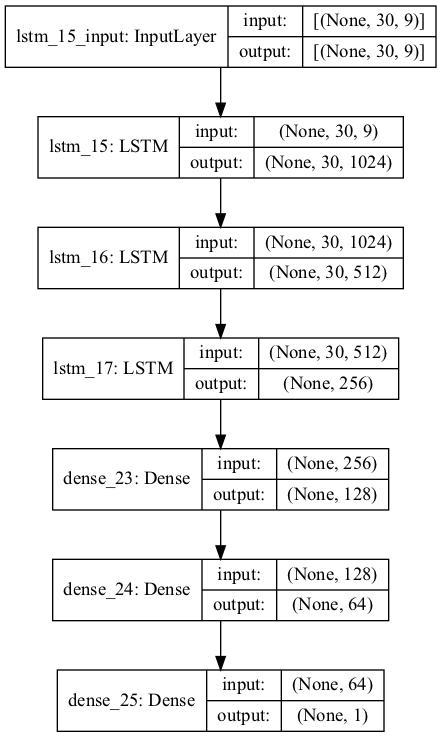

In [32]:
# plot model structure (Generator)
create_dir_if_not_exist(MODEL_STRUCTURE_PATH)
plot_model(
    # make_generator(input_dim=X_train_hk[fns_hk[0]].shape[1],
    #                 feature_cnt=X_train_hk[fns_hk[0]].shape[2]
    #                 ),
    make_generator(input_dim=X_train_hk.shape[1],
                    feature_cnt=X_train_hk.shape[2]
                    ),
    show_shapes=True,
    show_layer_names=True,
    to_file="{}/GAN_generator_structure.png".format(MODEL_STRUCTURE_PATH)
)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 16, 32)            128       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 8, 64)             10304     
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 64)             256       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 4, 128)            41088     
_________________________________________________________________
batch_normalization_9 (Batch (None, 4, 128)            512       
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)             

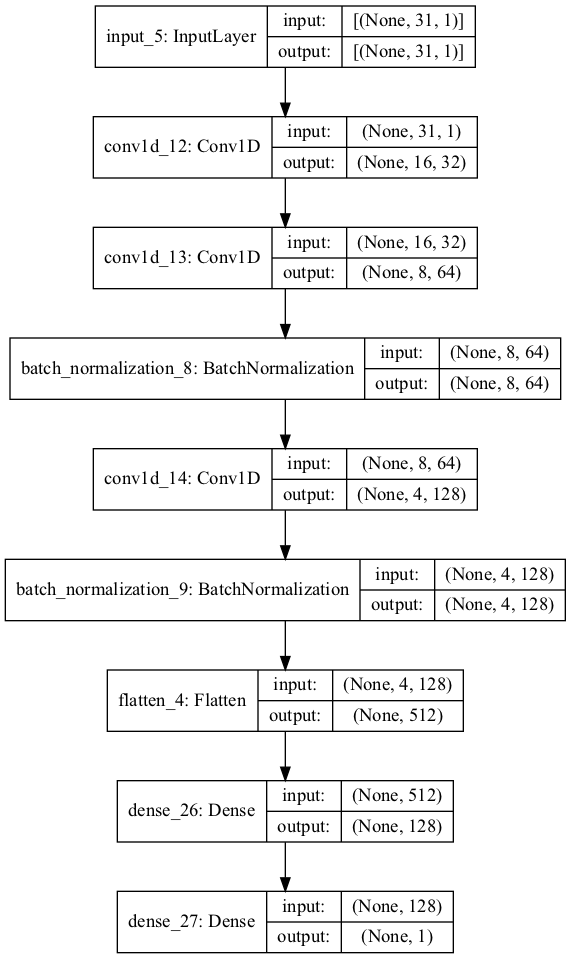

In [33]:
# plot model structure (Discriminator)
create_dir_if_not_exist(MODEL_STRUCTURE_PATH)
plot_model(
    make_discriminator(feature_cnt=X_train_hk.shape[2]),
    show_shapes=True,
    show_layer_names=True,
    to_file="{}/GAN_generator_structure.png".format(MODEL_STRUCTURE_PATH)
)

### Model training

In [34]:
create_dir_if_not_exist(HK_MODELS_CHECKPOINT_PATH)
create_dir_if_not_exist(US_MODELS_CHECKPOINT_PATH)
create_dir_if_not_exist(hk_gan_training_checkpoint_file_path)
create_dir_if_not_exist(us_gan_training_checkpoint_file_path)

In [35]:
# ref:
# Lin, H., Chen, C., Huang, G., & Jafari, A. (2021). Stock price prediction using Generative Adversarial Networks. Journal of Computer Science, (17(3), 188–196. doi:10.3844/jcssp.2021.188.196
# github: https://github.com/hungchun-lin/Stock-price-prediction-using-GAN
# Tensorflow doc:
# https://www.tensorflow.org/tutorials/generative/dcgan
class GAN:
    def __init__(self,
                 generator: tf.keras.models.Model,
                 discriminator: tf.keras.models.Model
                 ):
        self.generator: tf.keras.models.Model = generator
        self.discriminator: tf.keras.models.Model = discriminator
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = Adam(0.00016)
        # self.generator_optimizer = SGD(0.0004) # from Lin et.al (2016)
        self.discriminator_optimizer = Adam(0.00016) 
        # self.discriminator_optimizer = SGD(0.02) # from Lin et.al (2016)
        self.checkpoint = tf.train.Checkpoint(
            generator_optimizer=self.generator_optimizer,
            discriminator_optimizer=self.discriminator_optimizer,
            generator=self.generator,
            discriminator=self.discriminator,
        )

    def generator_loss(self, d_output_fake):
        # use tf.ones_like(...) to decrease the forecast error loss in generator
        # g_loss = binary_crossentropy(
        #     tf.ones_like(d_output_fake),
        #     d_output_fake,
        #     from_logits=True
        # )
        g_loss = self.cross_entropy(
            tf.ones_like(d_output_fake),
            d_output_fake,
        )

        return g_loss

    def discriminator_loss(self, d_output_real, d_output_fake):
        # "Classifying Real Y into class 1 and Fake Y into class 0",
        #   said Zhou et.al. (2018). Stock market prediction on high-frequency data using generative adversarial nets.
        # real_loss = binary_crossentropy(
        #     tf.ones_like(d_output_real), # to confuse the discriminator
        #     d_output_real,
        #     from_logits=True
        # )
        # fake_loss = binary_crossentropy(
        #     tf.zeros_like(d_output_fake), # to confuse the discriminator
        #     d_output_fake,
        #     from_logits=True
        # )
        real_loss = self.cross_entropy(
            tf.ones_like(d_output_real), # to confuse the discriminator
            d_output_real,
        )
        fake_loss = self.cross_entropy(
            tf.zeros_like(d_output_fake), # to confuse the discriminator
            d_output_fake,
        )
        d_loss = real_loss + fake_loss
        return d_loss

    @tf.function # compile the method
    def train_step(self, real_x, real_y, real_y_gan):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # get generated y values
            generated_y = self.generator(real_x, training=True)

            # reshape the data
            real_y_reshaped = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
            generated_y_reshaped = tf.reshape(generated_y, [generated_y.shape[0], generated_y.shape[1], 1])

            # concat the y values data into: y_t-30, y_t-29, y_t-28, ..., y_t-1, ^y_t or y_t
            #  where the y_t-n is from the real data, and the y_t is generated/obtained from LSTM/training data, respectively
            d_data_real = tf.concat([real_y_reshaped, real_y_gan], axis=1)
            d_data_fake = tf.concat([tf.cast(generated_y_reshaped, tf.float64), real_y_gan], axis=1)

            # tf.print("d_data_real: {}".format(d_data_real))

            # feed the data into the discriminator, in sequence: 1. real, 2. fake
            d_output_real = self.discriminator(d_data_real, training=True)
            d_output_fake = self.discriminator(d_data_fake, training=True)

            # calc the loss of respective models
            g_loss = self.generator_loss(d_output_fake)
            d_loss = self.discriminator_loss(d_output_real, d_output_fake)

        gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(
            zip(
                gradients_of_generator,
                self.generator.trainable_variables
            )
        )

        self.discriminator_optimizer.apply_gradients(
            zip(
                gradients_of_discriminator,
                self.discriminator.trainable_variables
            )
        )

        # tf.print('d_loss: {} - g_loss: {}'.format(d_loss, g_loss))
        return real_y, generated_y, {'d_loss': d_loss, 'g_loss': g_loss}

    def train(self, real_x, real_y, real_y_gan, model_save_path, checkpoint_save_path):
        train_history = {}
        train_history["d_loss"] = []
        train_history["g_loss"] = []
        train_history["epoch"] = []

        real_price = []
        predicted_price = []

        train_dataset = tf.data.Dataset.from_tensor_slices((real_x, real_y, real_y_gan))
        train_dataset = train_dataset.batch(BATCH_SIZE)

        # restore checkpoints
        try:
            self.checkpoint.restore(
                tf.train.latest_checkpoint(checkpoint_save_path)
            )
            print("Checkpoint found and restored, from {}.".format(checkpoint_save_path))
        except tf.errors.NotFoundError:
            print("Checkpoint not found, training from stretch.")

        for epoch in range(TRAIN_EPOCHS):
            print("\nStart of Epoch {}".format(epoch + 1))
            start_time = time.time()

            for step, (x_batch_train, y_batch_train, y_gan_batch_train) in enumerate(train_dataset):

                # do train
                tmp_real_price, tmp_fake_price, tmp_loss = self.train_step(
                    # real_x = real_x,
                    # real_y = real_y,
                    # real_y_gan = real_y_gan,
                    real_x = x_batch_train,
                    real_y = y_batch_train,
                    real_y_gan = y_gan_batch_train
                )

                # save to history lists
                train_history["d_loss"].append(tmp_loss["d_loss"].numpy()) # use .numpy() to convert from Tensor to numpy nd-array
                train_history["g_loss"].append(tmp_loss["g_loss"].numpy())
                train_history["epoch"].append(epoch)

                # real_price.append(tmp_real_price.numpy())
                # predicted_price.append(tmp_fake_price.numpy())

                real_price = [] # clear the last price
                real_price.append(tmp_real_price.numpy())

                predicted_price = []
                predicted_price.append(tmp_fake_price.numpy())

                if step % 15 == 0:
                    print("\nTraining loss (for one batch) at step {}:".format(
                        step,
                    ))
                    print("Discriminator loss: {} - Generator loss: {} -".format(
                        tmp_loss["d_loss"].numpy(),
                        tmp_loss["g_loss"].numpy()
                    ))
                    print("Seen so far: {} samples".format((step + 1) * BATCH_SIZE))

                    # Save model per 15 steps
                    tf.keras.models.save_model(self.generator, model_save_path)
                    # self.checkpoint.save(file_prefix=checkpoint_save_path + "/ckpt-")
                    print("Generator model saved.")

            # # Save model per 15 epochs
            # if (epoch + 1) % 15 == 0:
            #     tf.keras.models.save_model(self.generator, model_save_path)
            #     self.checkpoint.save(file_prefix=checkpoint_save_path + "/ckpt-")
            #     print("Generator model saved.")

            end_time = time.time()

            print("\nFinished Epoch: {} - {}s".format(epoch+1, end_time - start_time))
            # print("Discriminator loss: {} - Generator loss: {} -".format(
            #     tmp_loss["d_loss"].numpy(),
            #     tmp_loss["g_loss"].numpy()
            # ))
            
        # Reshape the predicted & real results
        predicted_price = np.array(predicted_price)
        predicted_price = predicted_price.reshape(
            predicted_price.shape[1],
            predicted_price.shape[2]
        )

        real_price = np.array(real_price)
        real_price = real_price.reshape(
            real_price.shape[1],
            real_price.shape[2]
        )

        return predicted_price, real_price, train_history, self.generator

##### Train BGRU model for Hong Kong Stocks

In [ ]:
# define HK model's generator and discriminator
generator = make_generator(
    input_dim=X_train_hk.shape[1],
    feature_cnt=X_train_hk.shape[2]
)

discriminator = make_discriminator(
    feature_cnt=X_train_hk.shape[2]
)

hk_gan = GAN(generator, discriminator)
hk_gan_predicted_y, hk_gan_real_y, hk_gan_history, hk_gan_model = hk_gan.train(
    real_x=X_train_hk,
    real_y=y_train_hk,
    real_y_gan=y_train_gan_hk,
    model_save_path=hk_gan_file_path,
    checkpoint_save_path=hk_gan_training_checkpoint_file_path,
)

if hk_gan_model is not None:
    hk_gan_model.save(hk_gan_file_path)
    print("Model Saved")

if hk_gan_history is not None:
    np.save(hk_gan_train_history_file_path, hk_gan_history)
    # np.save(hk_bgru_train_history_file_path, hk_bgru_history)
    print("History Saved")

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16, 32)            128       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 8, 64)             10304     
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 64)             256       
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 4, 128)            41088     
_________________________________________________________________
batch_normalization_11 (Batc (None, 4, 128)            512       
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)             

/Users/wilson/miniforge3/envs/tfenv/lib/python3.9/site-packages/keras/backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(



Training loss (for one batch) at step 0:
Discriminator loss: 1.5552074909210205 - Generator loss: 0.7254438996315002 -
Seen so far: 1024 samples
Generator model saved.

Training loss (for one batch) at step 15:
Discriminator loss: 1.440140962600708 - Generator loss: 0.6851425766944885 -
Seen so far: 16384 samples
Generator model saved.

Training loss (for one batch) at step 30:
Discriminator loss: 1.4392575025558472 - Generator loss: 0.9760357141494751 -
Seen so far: 31744 samples
Generator model saved.

Training loss (for one batch) at step 45:
Discriminator loss: 1.4200292825698853 - Generator loss: 0.5572689771652222 -
Seen so far: 47104 samples
Generator model saved.

Training loss (for one batch) at step 60:
Discriminator loss: 1.3789746761322021 - Generator loss: 0.6474054455757141 -
Seen so far: 62464 samples
Generator model saved.

Training loss (for one batch) at step 75:
Discriminator loss: 1.3223345279693604 - Generator loss: 0.8042075634002686 -
Seen so far: 77824 samples


##### Train BGRU model for United States stocks

In [ ]:
# define US model's generator and discriminator
generator = make_generator(
    input_dim=X_train_us.shape[1],
    feature_cnt=X_train_us.shape[2]
)

discriminator = make_discriminator(
    feature_cnt=X_train_us.shape[2]
)

us_gan = GAN(generator, discriminator)
us_gan_predicted_y, us_gan_real_y, us_gan_history, us_gan_model = us_gan.train(
    real_x=X_train_us,
    real_y=y_train_us,
    real_y_gan=y_train_gan_us,
    model_save_path=us_gan_file_path,
    checkpoint_save_path=us_gan_training_checkpoint_file_path,
)

if us_gan_model is not None:
    us_gan_model.save(us_gan_file_path)
    print("Model Saved")

if us_gan_history is not None:
    np.save(us_gan_train_history_file_path, us_gan_history)
    print("History Saved")

### plot training history

In [16]:
def plot_history(history_dict, title):
    """
    Plot the training history
    :param history_dict: dict, the training history, should be a dict (from keras' history.history)
    :param title: str, plot title, example: "HK BGRU Model - {}", the program will replace the {} with the relevant metric name
    :return:
    """
    # metrics = ["loss",
    #        "mean_absolute_error",
    #        "root_mean_squared_error",
    #        # "mean_absolute_percentage_error" # disable plot of MAPE as the normalized data consists of 0 or nearly 0, the MAPE is unreasonably high, will recalculate in evaluation stage
    #        # "val_loss",
    #        # "val_mean_absolute_error",
    #        # "val_root_mean_squared_error",
    #        # "val_mean_absolute_percentage_error"
    #        ]

    # for metric in metrics:
    plt.figure(figsize=(14, 5), dpi=500, facecolor="white")
    # metrics.replace("_", "").title()

    # parse as float
    history_dict["d_loss"] = list(map(float, history_dict["d_loss"]))
    history_dict["g_loss"] = list(map(float, history_dict["g_loss"]))

    plt.plot(history_dict["d_loss"][:1900], label="D_loss")
    plt.plot(history_dict["g_loss"][:1900], label="G_loss")
    plt.xlabel("Epochs")
    plt.ylabel('Loss (Binary cross-entropy)')
    plt.title(title.format("Loss (Binary cross-entropy)"))
    plt.legend()
    create_dir_if_not_exist(MODEL_TRAIN_HISTORY_DIAGRAMS_PATH)
    # plt.savefig('{}/{}.png'.format(MODEL_TRAIN_HISTORY_DIAGRAMS_PATH, plt.gca().get_title()))
    plt.show()

In [9]:
def read_his_file(filepath, is_csv = False) -> dict:
    result = None
    if is_csv:
        # read from csv and convert to dict
        reader = csv.DictReader(open(filepath))

        result = {}
        for row in reader:
            for column, value in row.items():  # consider .iteritems() for Python 2
                result.setdefault(column, []).append(value)

    else:
        result = np.load(filepath, allow_pickle=True).item()

    return result

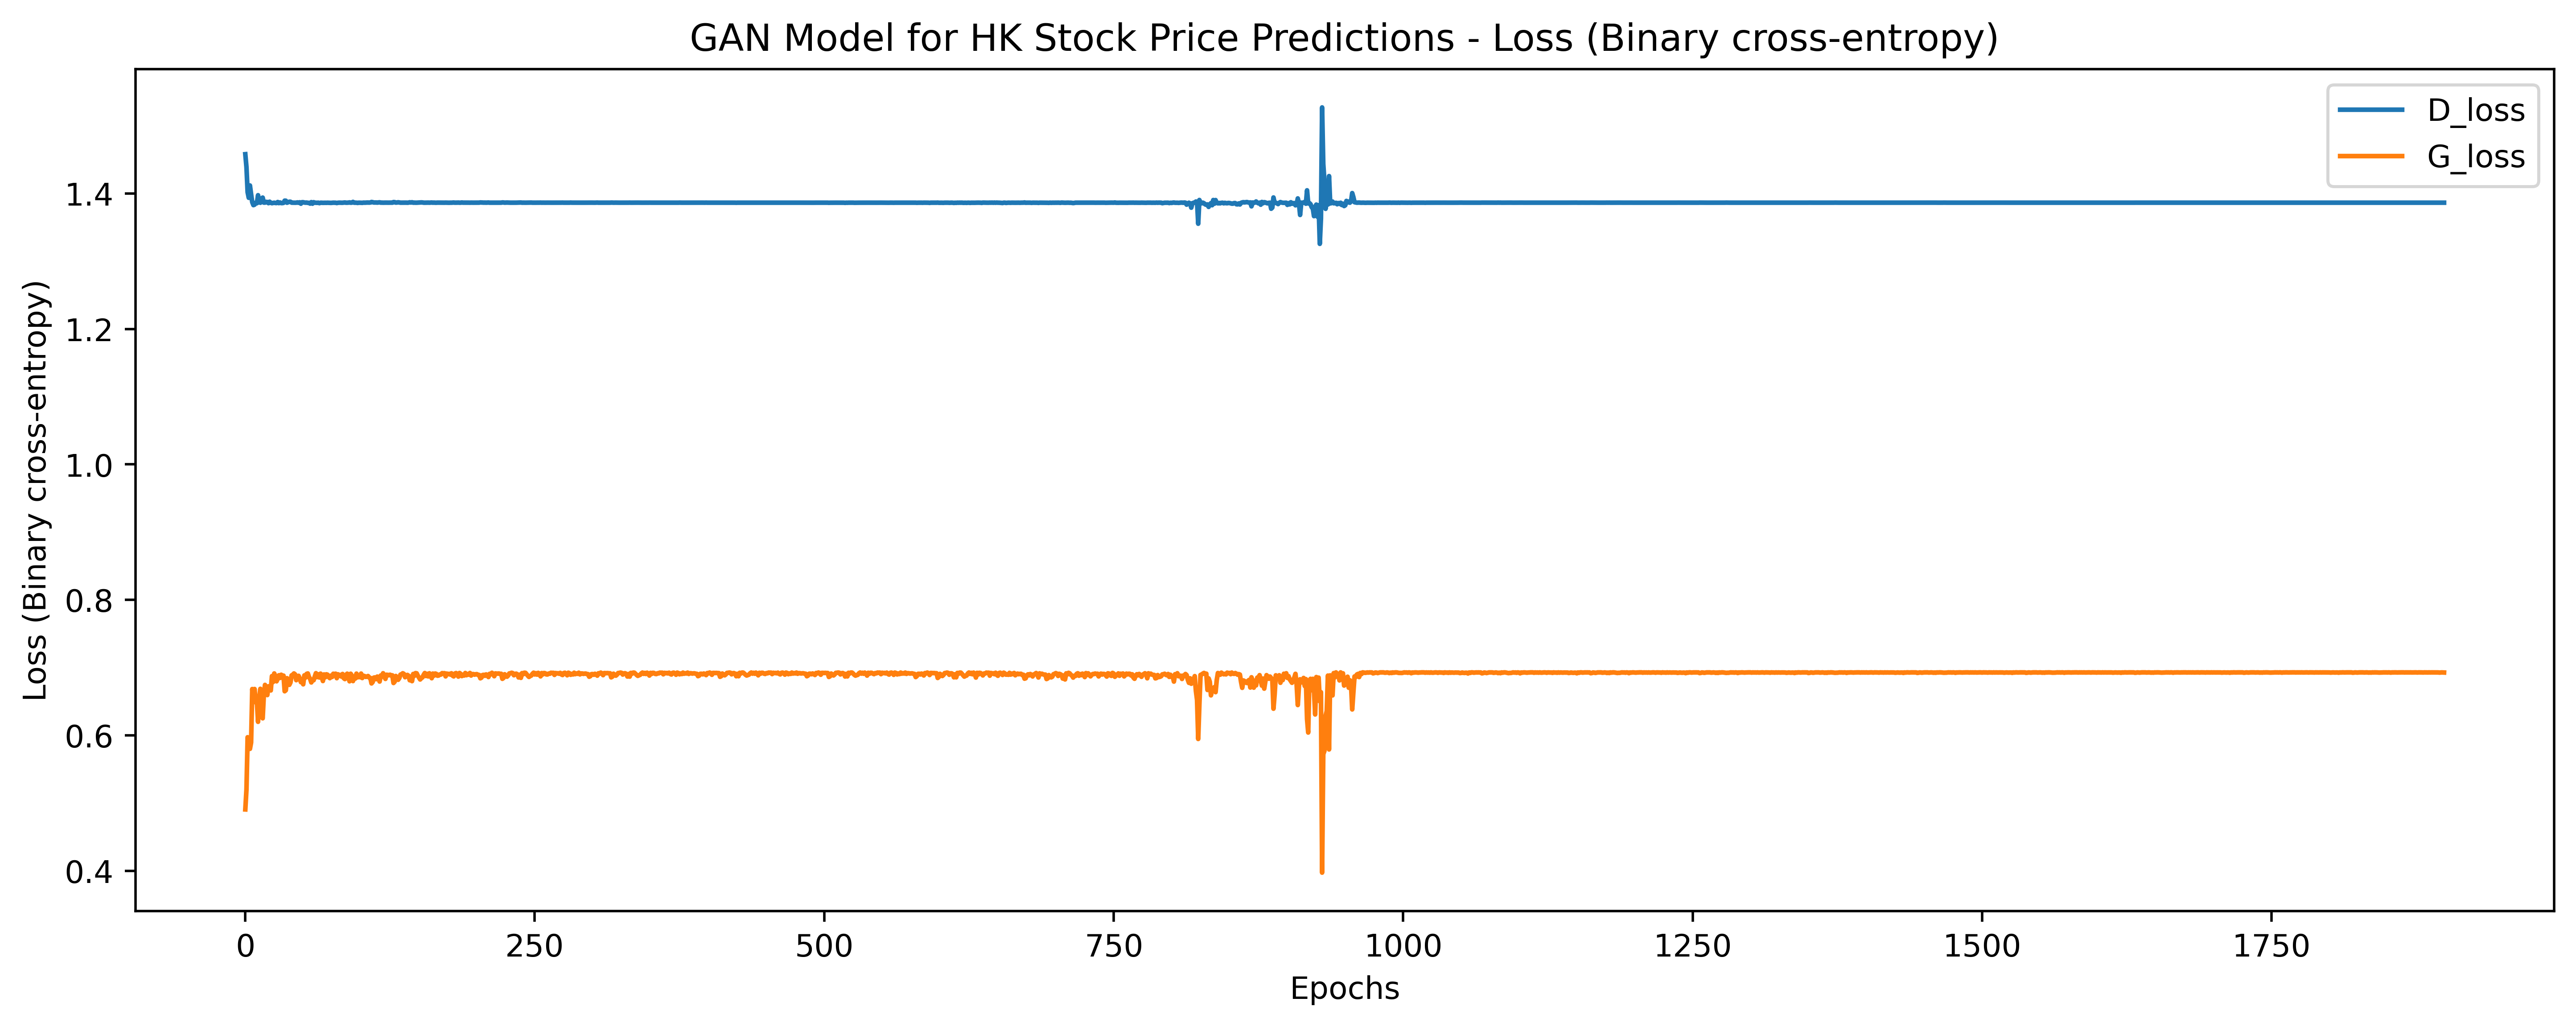

In [23]:
hk_gan_history_dict = read_his_file(hk_gan_train_history_file_path)

plot_history(hk_gan_history_dict, "GAN Model for HK Stock Price Predictions - {}")

In [19]:
hk_gan_history_dict['epoch'][1800]

19

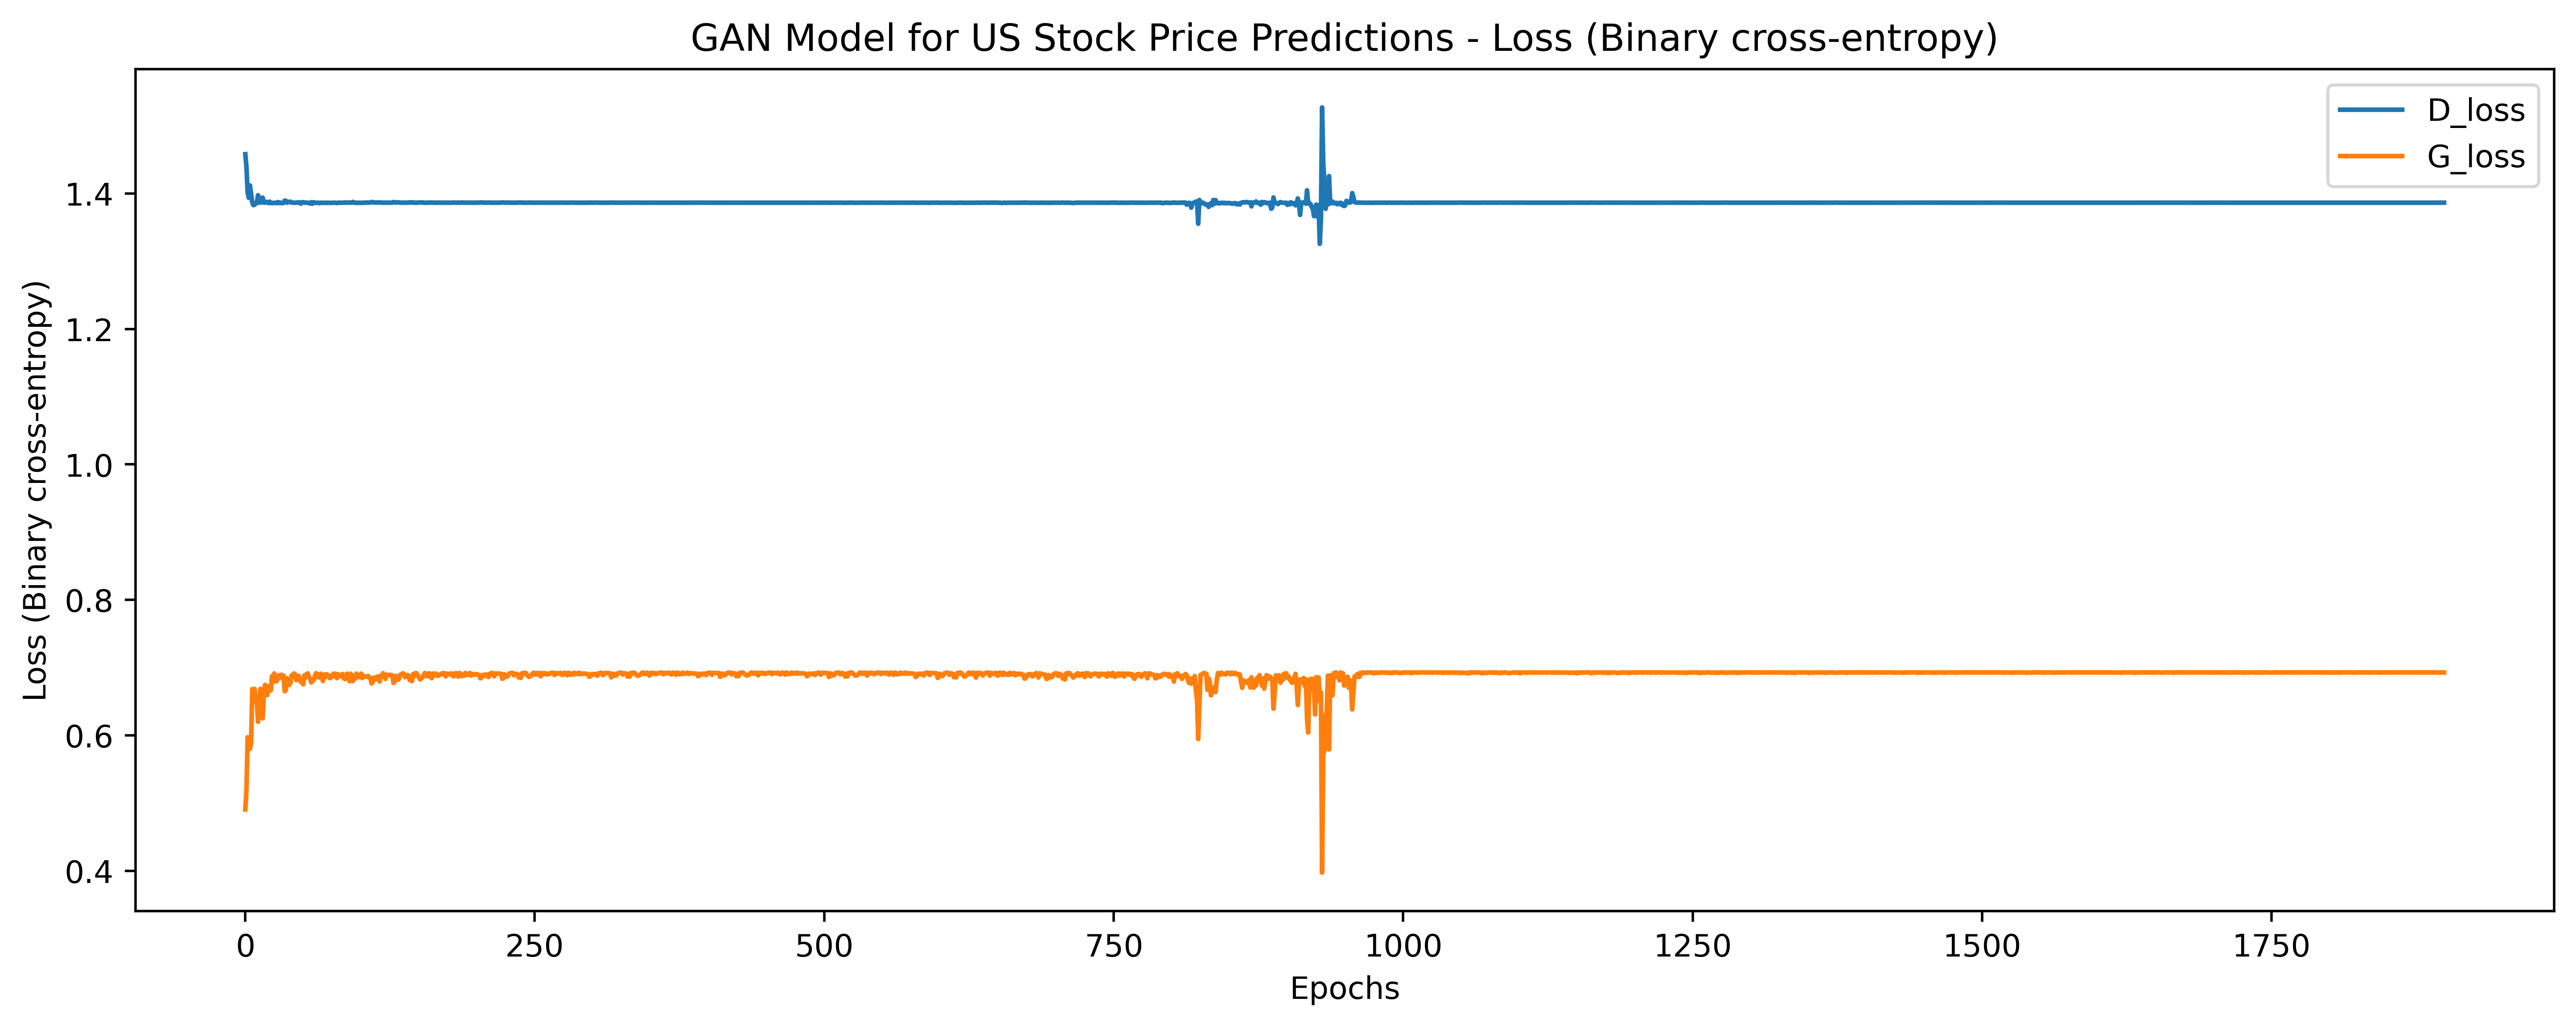

In [24]:
us_gan_history_dict = read_his_file(us_gan_train_history_file_path)

plot_history(hk_gan_history_dict, "GAN Model for US Stock Price Predictions - {}")
